In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import pandas as pd

Full code:
https://github.com/ged-lab/khmer/pull/257/files

Relevant code:
https://github.com/ged-lab/khmer/blob/3a6dfed60111c807f7c6d26cfc8c5bb52e6f1aca/lib/hllcounter.cc#L320

``` cpp
void HLLCounter::consume_fasta(
        read_parsers::IParser *parser,
        unsigned int &      total_reads,
        unsigned long long &    n_consumed,
        CallbackFn      callback,
        void *      callback_data) {

    read_parsers::Read read;
    HLLCounter** counters;
    unsigned int *n_consumed_partial;
    unsigned int *total_reads_partial;

    n_consumed = 0;

    #pragma omp parallel
    {
        #pragma omp single
        {
            counters = (HLLCounter**)calloc(omp_get_num_threads(),
                                            sizeof(HLLCounter*));
            n_consumed_partial = (unsigned int*)calloc(omp_get_num_threads(),
                                            sizeof(unsigned int));
            total_reads_partial = (unsigned int*)calloc(omp_get_num_threads(),
                                            sizeof(unsigned int));

            for (int i=0; i < omp_get_num_threads(); i++) {
                HLLCounter *newc = new HLLCounter(this->p, this->_ksize);
                counters[i] = newc;
            }
        }

        #pragma omp single
        {
            while (!parser->is_complete()) {
                // Iterate through the reads and consume their k-mers.
                try {
                    read = parser->get_next_read();

                    #pragma omp task default(none) firstprivate(read) \
                     shared(counters, n_consumed_partial, total_reads_partial)
                    {
                        bool is_valid;
                        int n, t = omp_get_thread_num();
                        n = counters[t]->check_and_process_read(read.sequence,
                                                                is_valid);
                        n_consumed_partial[t] += n;
                        if (is_valid)
                            total_reads_partial[t] += 1;
                    }
                } catch (read_parsers::NoMoreReadsAvailable) {
                }

            } // while reads left for parser
        }
        #pragma omp taskwait

        #pragma omp single
        {
            for (int i=0; i < omp_get_num_threads(); ++i) {
                this->merge(*counters[i]);
                delete counters[i];
                n_consumed += n_consumed_partial[i];
                total_reads += total_reads_partial[i];;
            }
            free(counters);
            free(n_consumed_partial);
            free(total_reads_partial);
        }
    }
}
```

In [ ]:
test_files = [(100000, '../outputs/test-small.fa'), (1000000, '../outputs/test-medium.fa'), (10000000, '../outputs/test-large.fa')]

In [3]:
#for N, fn in test_files:
#    !python ../scripts/make-random-genome-with-repeats.py -l {N} > {fn}

In [7]:
screed_results = {}
for _, fn in test_files:
    results = %timeit -n 1 -r 10 -o !python ../scripts/unique_kmers_hll.py {fn} 21
    screed_results[fn] = results.all_runs

102719
102719
102719
102719
102719
102719
102719
102719
102719
102719
1 loops, best of 10: 210 ms per loop
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1 loops, best of 10: 510 ms per loop
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
1 loops, best of 10: 3.4 s per loop


In [8]:
readparser_results = {}
for _, fn in test_files:
    results = %timeit -n 1 -r 10 -o !python ../scripts/unique_kmers_hll_consume.py {fn} 21
    readparser_results[fn] = results.all_runs

102719
102719
102719
102719
102719
102719
102719
102719
102719
102719
1 loops, best of 10: 221 ms per loop
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1 loops, best of 10: 542 ms per loop
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
1 loops, best of 10: 3.69 s per loop


In [11]:
readparser_results = {}
for _, fn in test_files:
    results = %timeit -n 1 -r 10 -o !OMP_NUM_THREADS=1 python ../scripts/unique_kmers_hll_consume.py {fn} 21
    readparser_results[fn] = results.all_runs

102719
102719
102719
102719
102719
102719
102719
102719
102719
102719
1 loops, best of 10: 212 ms per loop
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1006246
1 loops, best of 10: 522 ms per loop
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
9938982
1 loops, best of 10: 3.52 s per loop


In [13]:
data = {}

data[1] = {
  'real': 52.660,
  'user': 52.505,
  'sys': 0.062
}

data[2] = {
  'real': 27.193,
  'user': 54.142,
  'sys': 0.082
}

data[4] = {
  'real': 14.042,
  'user': 55.790,
  'sys': 0.093
}

data[8] = {
  'real': 7.370,
  'user': 58.318,
  'sys': 0.084
}

data[16] = {
  'real': 3.773,
  'user': 59.251,
  'sys': 0.094
}

In [223]:
df = pd.DataFrame(data).T

In [232]:
data = {
40: 2.712,
32: 3.106,
24: 3.547,
16: 5.063,
12: 6.637,
8: 8.814,
4: 15.951,
2: 29.834,
1: 43.523
}

In [233]:
se = pd.Series(data)

In [234]:
se[1] / se

1      1.000000
2      1.458839
4      2.728544
8      4.937940
12     6.557631
16     8.596287
24    12.270369
32    14.012556
40    16.048304
dtype: float64

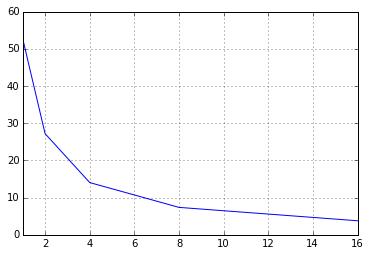

In [41]:
df['real'].plot()

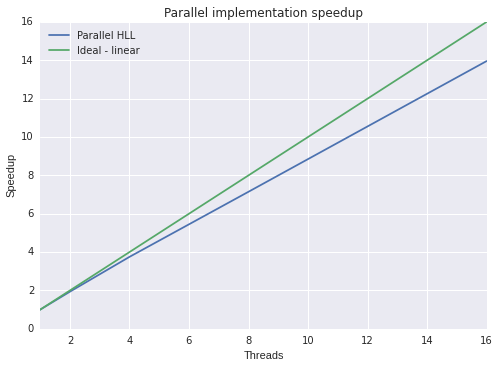

In [49]:
(df['real'][1] / df['real']).plot(label='Parallel HLL')
plt.plot(range(0, 17), range(0, 17), label="Ideal - linear")
plt.ylabel("Speedup")
plt.xlabel("Threads")
plt.legend(loc='best')
plt.title("Parallel implementation speedup")

# Profiling with TAU

Talk about:
- problems

In [2]:
from collections import defaultdict
infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)

import pandas as pd


Panel5D = pd.core.panelnd.create_nd_panel_factory(
    klass_name='Panel5D',
    orders=['replicate', 'vector_size', 'threads', 'function_name', 'metric'],
    slices={'vector_size': 'vector_size', 'threads': 'threads',
                 'function_name': 'function_name',
                 'metric': 'metric'},
    slicer=pd.core.panel4d.Panel4D,
    aliases={'major': 'function_name', 'minor': 'metric'},
    stat_axis=2)


Panel5D = pd.core.panelnd.create_nd_panel_factory(
    klass_name   = 'Panel5D',
    orders  = [ 'cool', 'labels','items','major_axis','minor_axis'],
    slices  = { 'labels' : 'labels', 'items' : 'items',
                'major_axis' : 'major_axis', 'minor_axis' : 'minor_axis' },
    slicer  = pd.core.panel4d.Panel4D,
    aliases = { 'major' : 'major_axis', 'minor' : 'minor_axis' },
    stat_axis    = 2)


def prepare_panels(expname):
    header = ['%Time', 'Exclusive msec', 'Inclusive total msec', '#Call', '#Subrs', 'Inclusive usec/call', 'Name']
    replicate_panels = defaultdict(dict)

    for r in REPLICATES:
        data = defaultdict(dict)
        for v in VECTOR_SIZE:
            for t in THREADS:
                tauprofile = "../workdir.1/{}/r{}/{}/{}/tauprofile".format(expname, r, v, t)
                header_started = None
                tv_data = defaultdict(list)
                with open(tauprofile, 'r') as f:
                    for line in f:
                        if line.startswith('-----') and header_started is None:
                            header_started = True
                        elif line.startswith('-----') and header_started:
                            break
                    for line in f:
                        function_data = line[:-1].strip().split()
                        if len(function_data) > len(header):
                            function_data = function_data[:len(header) - 1] + [" ".join(function_data[len(header) - 1:])]
                        for metric, value in zip(header, function_data):
                            if not value.isalpha():
                                try:
                                    value = int(value)
                                except ValueError:
                                    try:
                                        value = float(value)
                                    except ValueError:
                                        pass
                            tv_data[metric].append(value)
                    data[v][t] = pd.DataFrame(tv_data, index=tv_data['Name'])
        replicate_panels[r] = pd.Panel4D(data)
    return replicate_panels

def parse_thread_name(f):
    for line in f:
        if all(v in line for v in ('NODE', 'CONTEXT', 'THREAD')):
            return line.strip().split(';')[-1].split(" ")[-1][:-1]
        elif 'FUNCTION SUMMARY' in line:
            return 'Summary'

def consume_header(f):
    header_started = None
    for line in f:
        if line.startswith('-----') and header_started is None:
            header_started = True
        elif line.startswith('-----') and header_started:
            break

def parse_functions(f):
    header = ['%Time', 'Exclusive msec', 'Inclusive total msec', '#Call', '#Subrs', 'Inclusive usec/call', 'Name']
    tv_data = defaultdict(list)
    for line in f:
        if not line.strip():
            break

        function_data = line[:-1].strip().split()
        if len(function_data) > len(header):
            function_data = function_data[:len(header) - 1] + [" ".join(function_data[len(header) - 1:])]
        for metric, value in zip(header, function_data):
            if metric == 'Inclusive total msec':
                value = float(value.replace(",", ''))
            elif not value.isalpha():
                try:
                    value = int(value)
                except ValueError:
                    try:
                        value = float(value)
                    except ValueError:
                        pass
            tv_data[metric].append(value)
    return tv_data

    
    
def prepare_panel(workdir="workdir", replicates=None, threads=(40, 32, 24, 16, 12, 8, 4, 2, 1)):
    data = infinite_defaultdict()
    if replicates is None:
        replicates = range(1, 31)

    for r in replicates:
        for t in threads:
            tauprofile = "../outputs/{}/{:02d}/{}/tauprofile".format(workdir, r, t)
            with open(tauprofile) as f:
                current_thread = parse_thread_name(f)
                counter = 0
                while current_thread != 'Summary':
                    consume_header(f)
                    tr_data = parse_functions(f)
                    data[r][t][int(current_thread)] = pd.DataFrame(tr_data, index=tr_data['Name'])
                    current_thread = parse_thread_name(f)
                    if current_thread is None:
                        break
            #print tr_data
            #data[r][t] = pd.DataFrame(tr_data, index=tr_data['Name'])
    return data

In [3]:
REPLICATES = range(1, 31)
THREADS = (1, 2, 4, 8, 12, 16, 24, 32, 40)

In [4]:
tr_data = prepare_panel('workdir.2', REPLICATES, threads=[40, 32, 24, 16, 12, 8, 4, 2, 1])
#tr_data = prepare_panel(workdir='workdir.3', replicates=[1], threads=[40, 20, 10, 4, 2, 1])

## Speedup

In [5]:
results = pd.Panel4D(tr_data[1])
# dimensions: results[# threads, thread id, function name, metric]
results.ix[:,:,:,:]

<class 'pandas.core.panelnd.Panel4D'>
Dimensions: 9 (labels) x 40 (items) x 374 (major_axis) x 7 (minor_axis)
Labels axis: 1 to 40
Items axis: 0 to 39
Major_axis axis: .TAU application to void khmer::~ThreadIDMap()
Minor_axis axis: #Call to Name

In [6]:
#times = results.ix[:,:,'int main(int, char **)','Inclusive usec/call'].mean() / 1000000
times = results.ix[:,:,'.TAU application','Inclusive usec/call'].mean() / 1000000

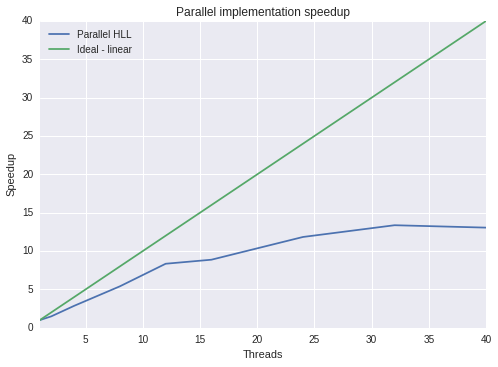

In [8]:
(times[1] / times).plot(label='Parallel HLL')
plt.plot(range(0, 41), range(0, 41), label="Ideal - linear")
plt.ylabel("Speedup")
plt.xlabel("Threads")
plt.legend(loc='best')
plt.title("Parallel implementation speedup")

In [7]:
times

1     45.386358
2     30.515854
4     15.871443
8      8.396647
12     5.436437
16     5.113503
24     3.833751
32     3.394706
40     3.476234
dtype: float64

## Max counts

In [18]:
max_counts = (results.ix[:,:,:,'Inclusive total msec']
    .mean()
    .dropna())
only_openmp = (max_counts[['OpenMP' in e for e in max_counts.index.values]]
    .sort(40, ascending=False))
only_openmp

,1,2,4,8,12,16,24,32,40
"parallel (parallel fork/join) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <334, 389>]",45367.000,30507.0000,15867.00000,8397.000000,5439.000000,5120.000000,3845.000000,3404.000000,3496.000000
"parallel (parallel begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <334, 389>]",45367.000,30506.5000,15866.50000,8393.125000,5433.833333,5111.250000,3831.416667,3392.906250,3474.250000
"single (single enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <352, 374>]",45367.000,30506.0000,15866.00000,8392.000000,5432.000000,5108.187500,3827.000000,3387.000000,3463.625000
"single (single begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <352, 374>]",45321.000,30396.0000,15765.00000,8278.000000,5325.000000,4997.000000,3709.000000,3255.000000,3422.000000
"single (barrier enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <352, 374>]",45.600,15308.0000,11924.00000,7357.125000,4988.166667,4795.687500,3672.458333,3285.281250,3378.075000
"task (task begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <359, 369>]",43458.000,29484.5000,15318.25000,8064.500000,5142.333333,4781.750000,3402.916667,2857.531250,2413.450000
"task (task create begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <359, 369>]",43434.000,28499.0000,13826.00000,6187.000000,3149.000000,2565.000000,748.000000,301.000000,52.000000
"single (single begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <336, 349>]",0.086,0.1660,0.58800,0.477000,0.453000,1.460000,2.620000,5.870000,7.970000
"single (single enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <336, 349>]",0.168,0.2085,0.40175,0.749250,0.968750,1.595687,2.603750,3.685313,5.938600
"single (barrier enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <336, 349>]",0.002,0.0650,0.13200,0.273750,0.569917,1.222563,1.966125,3.287938,5.295925


In [17]:
only_openmp

,1,2,4,8,12,16,24,32,40
"parallel (parallel fork/join) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <334, 389>]",45367.000,30507.000,15867.000,8397.000,5439.000,5120.000,3845.000,3404.000,3496.000
"parallel (parallel begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <334, 389>]",45367.000,30507.000,15867.000,8394.000,5435.000,5112.000,3836.000,3400.000,3483.000
"single (barrier enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <352, 374>]",45.600,30506.000,15865.000,8392.000,5432.000,5108.000,3827.000,3387.000,3464.000
"single (single enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <352, 374>]",45367.000,30506.000,15866.000,8392.000,5432.000,5109.000,3827.000,3387.000,3464.000
"single (single begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <352, 374>]",45321.000,30396.000,15765.000,8278.000,5325.000,4997.000,3709.000,3255.000,3422.000
"task (task begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <359, 369>]",43458.000,30393.000,15798.000,8324.000,5332.000,4960.000,3676.000,3198.000,3215.000
"task (task create begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <359, 369>]",43434.000,28499.000,13826.000,6187.000,3149.000,2565.000,748.000,301.000,52.000
"single (single enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <336, 349>]",0.168,0.209,0.634,0.897,1.350,2.190,7.050,7.340,11.000
"single (single begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <336, 349>]",0.086,0.166,0.588,0.477,0.453,1.460,2.620,5.870,7.970
"single (barrier enter/exit) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <336, 349>]",0.002,0.129,0.190,0.314,0.836,1.590,3.260,5.640,7.450


## Sort by %Time

In [ ]:
(results.ix[40,:,:,:]
    .dropna()
    .mean(numeric_only=True)
    .sort("%Time", ascending=False)
    .head(12))

In [ ]:
(results.ix[20,0,:,:]
    .sort("%Time", ascending=False)
    .head(12))

## Only OpenMP functions

In [134]:
ts = {}
for t in THREADS[1:]:
   print t 
   ts[t] = (results.ix[t,1,:,:]
   [results.ix[t,1,:,:]
       .Name.str.contains("task")
       .replace(pd.np.NAN, False)]
   .sort("%Time", ascending=False))["%Time"]

2
4
8
12
16
24
32
40


In [135]:
t8 = (results.ix[8,1,:,:]
   [results.ix[8,1,:,:]
       .Name.str.contains("task ")
       .replace(pd.np.NAN, False)]
   .sort("%Time", ascending=False))["%Time"]


In [63]:
t16 = (results.ix[16,1,:,:]
   [results.ix[16,1,:,:]
       .Name.str.contains("task ")
       .replace(pd.np.NAN, False)]
   .sort("%Time", ascending=False))


In [64]:
t32 = (results.ix[32,1,:,:]
   [results.ix[32,1,:,:]
       .Name.str.contains("task ")
       .replace(pd.np.NAN, False)]
   .sort("%Time", ascending=False))


In [153]:
omp_tasks = pd.DataFrame()
for t in THREADS[1:]:
    omp_tasks[t] = ts[t]

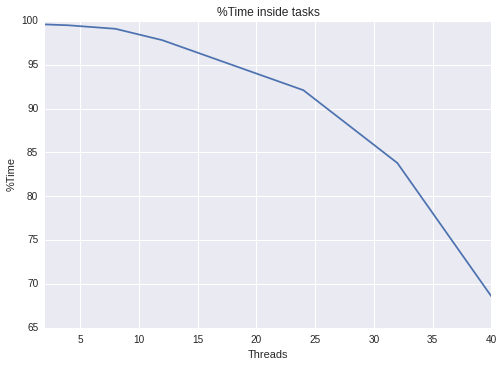

In [172]:
omp_tasks.ix[0].plot()
plt.title("%Time inside tasks")
plt.xlabel("Threads")
plt.ylabel("%Time")

In [157]:
omp_tasks

,2,4,8,12,16,24,32,40
"task (task begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <359, 369>]",99.6,99.5,99.1,97.8,95.9,92.1,83.8,68.6
"taskwait (taskwait begin/end) [OpenMP location: file:/root/khmer/lib/hllcounter.cc <375, 375>]",0,0,0,0,0,0,0,0
